In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [19]:
import copernicus_marine_client as copernicus_marine

In [2]:
df1 = xr.open_dataset('working_ds_third_positions.nc')
df1

<xarray.Dataset>
Dimensions:          (N_GRD: 3908)
Dimensions without coordinates: N_GRD
Data variables: (12/17)
    LATITUDE         (N_GRD) float64 ...
    LONGITUDE        (N_GRD) float64 ...
    PROFILER_TYPE    (N_GRD) float64 ...
    CYCLE_NUMBER     (N_GRD) float64 ...
    WMO              (N_GRD) float64 ...
    GROUNDING_DATE   (N_GRD) datetime64[ns] ...
    ...               ...
    LATITUDE_C0      (N_GRD) float64 ...
    LATITUDE_C1      (N_GRD) float64 ...
    LONGITUDE_C0     (N_GRD) float64 ...
    LONGITUDE_C1     (N_GRD) float64 ...
    LATITUDE_C2      (N_GRD) float64 ...
    LONGITUDE_C2     (N_GRD) float64 ...
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [16]:
def get_coords_corrected_cli(du):    
    # Set parameters
    ds_id = "cmems_mod_glo_phy_my_0.083deg-climatology_P1M-m"
    print("Downloading velocities on CMEMS : ",ds_id)
    # Load xarray dataset
    vel_glo = copernicus_marine.open_dataset(
        dataset_id = ds_id,
        minimum_longitude = du.LONGITUDE.values-.2,
        maximum_longitude = du.LONGITUDE.values+.2,
        minimum_latitude = du.LATITUDE.values-.2,
        maximum_latitude = du.LATITUDE.values+.2,
        start_datetime = '1993-01-01',
        end_datetime = '1993-12-31',
        variables = ["uo","vo"]
    )
    vel_glo = vel_glo.mean('time')
    print("Calculating corrected grounding position ...")
    ascent_duration = int((du.PROFILE_DATE - du.GROUNDING_DATE).values)/(1e9)
    uom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['uo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    vom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['vo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    azim = np.degrees(np.arctan2(uom,vom))
    dist = np.sqrt(uom**2 + vom**2)
    origin = Geodesic().direct([du.LONGITUDE.values,du.LATITUDE.values],azim,dist)    
    return origin[0][0], origin[0][1], vel_glo

Calculating corrected grounding position ...
Plotting


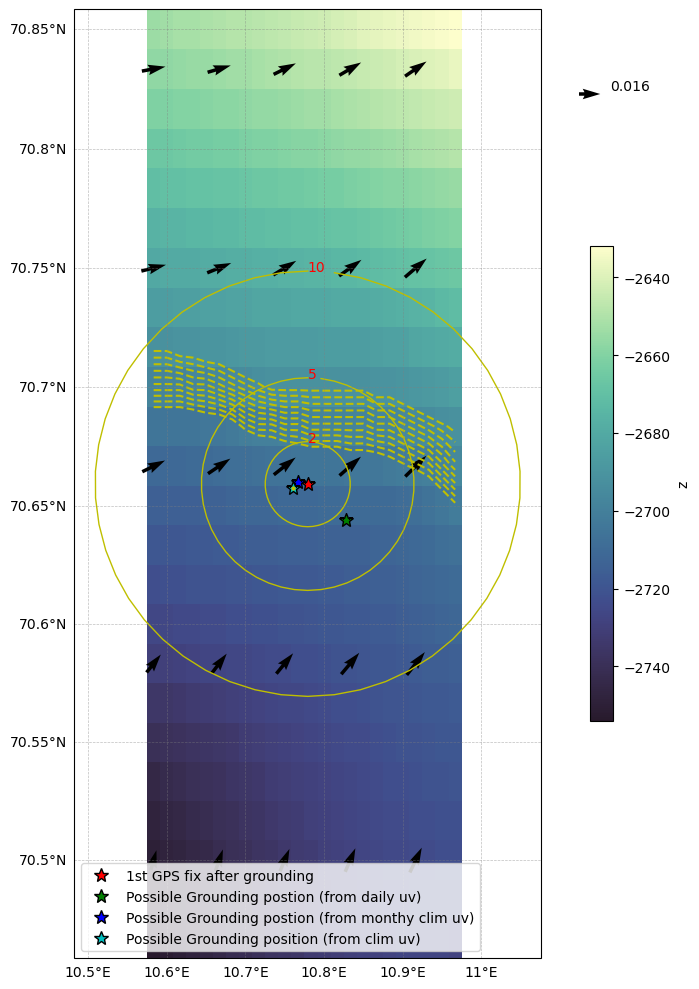

In [25]:
i = 2550
du = df1.isel(N_GRD=i)

lon_ci0,lat_ci0,vel = get_coords_corrected_cli(df1.isel(N_GRD=i))
vel = vel.where(vel['depth']<du.GROUNDING_DEPTH.values,drop=True).mean('depth')

print("Plotting")
bathy = etopo
#bathy = gebco
bdim={'x':'x','y':'y','z':'z'}
#bdim={'x':'lon','y':'lat','z':'elevation'}
rsize=.2

fig=plt.figure(figsize=(10,10),tight_layout=True)
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
            drop=True)[bdim['z']].plot(cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())
bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
            drop=True)[bdim['z']].plot.contour(x=bdim['x'],y=bdim['y'],levels=np.arange(-du['GROUNDING_DEPTH']-5,-du['GROUNDING_DEPTH']+5),colors='y',ax=ax, transform=ccrs.PlateCarree())



ax.plot(du['LONGITUDE'],du['LATITUDE'],'*r', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='1st GPS fix after grounding')
ax.plot(du['LONGITUDE_C0'],du['LATITUDE_C0'],'*g', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Possible Grounding postion (from daily uv)')
ax.plot(du['LONGITUDE_C1'],du['LATITUDE_C1'],'*b', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Possible Grounding postion (from monthy clim uv)')
ax.plot(du['LONGITUDE_C2'],du['LATITUDE_C2'],'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Possible Grounding position (from clim uv)')

vel.plot.quiver(x='longitude',y='latitude',u='uo',v='vo',ax=ax,transform=ccrs.PlateCarree())
ax.plot(lon_ci0,lat_ci0,'.y', markersize=6, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree(),zorder=11)

plt.legend()

rads = [2,5,10]
for r in rads:
    PTS=np.array(Geodesic().circle(lon=du['LONGITUDE'].values,lat=du['LATITUDE'].values,radius=r*1000,n_samples=50))
    ax.plot(PTS[:,0],PTS[:,1],'y-',linewidth=1, transform=ccrs.PlateCarree())
    ax.text(PTS[0,0],PTS[0,1],str(r),color='r',transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER